# Importing Qrisp or Qiskit circuits into TQEC

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

from IPython.display import display, clear_output
from pathlib import Path

# NB !!! 
# The notebook requires installing the following libraries (and they *will* install on top of existing TQEC dependencies):
# - Topologiq: `pip install git+https://github.com/jbolns/topologiq.git`
# - Qrisp (if using a Qrisp circuit): `pip install qrisp`
# - Qiskit (if using a Qiskit circuit): `prip install qiskit`

This notebook illustrates the process of importing into TQEC circuits originally created with external software/frameworks.

Currently, the notebook contains examples of circuits designed with [Qrisp](https://github.com/eclipse-qrisp/qrisp) and [Qiskit](https://github.com/Qiskit/qiskit), but the same approach could be used to handle a circuit designed with *any* framework capable of exporting to OpenQASM. 

The full process consists of four critical steps:
- A circuit is created using either Qrisp or Qiskit and transpiled into OpenQASM. 
- The QASM circuit is imported int [PyZX](https://github.com/zxcalc/pyzx) and transformed into a ZX-graph.
- We perform algorithmic lattice surgery of the ZX graph using [topologiq](https://github.com/jbolns/topologiq).
- We import the resulting lattice surgery into [TQEC](https://github.com/tqec/tqec) and use it to produce a Stim circuit and run simulations.

## Base circuit creation

Let's choose if we want to use Qrisp or a Qiskit as `base_framework`, i.e., the framework used to design the foundational circuit.

In [2]:
base_platform = "qiskit"  # options currently available ["qrisp", "qiskit"]

Let's now create a circuit using the selected `base_platform`. The example chosen for this notebook is a Steane code.

In [3]:
from qrisp import QuantumBool, h, cx, measure
from qrisp.jasp import make_jaspr

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import qiskit.qasm2 as qasm2

# Function to generate a Qrisp circuit
def steane_circuit_qrisp():
    """Function to generate the Steane code encoding circuit in Qrisp.
    Credits: Purva Thakre."""

    # define the ancilla and data qubits
    num_ancilla = 3
    num_data = 7

    ancilla_qubits = [QuantumBool() for _ in range(num_ancilla)]
    data_qubits = [QuantumBool() for _ in range(num_data)]

    h(ancilla_qubits[0])
    cx(ancilla_qubits[0], data_qubits[0])
    cx(ancilla_qubits[0], data_qubits[1])
    cx(ancilla_qubits[0], data_qubits[2])
    cx(ancilla_qubits[0], data_qubits[3])
    h(ancilla_qubits[0])

    # we will skip adding measurement gates because pyzx/qasm runs into issues
    # while compiling the circuit
    # measure(ancilla_qubits[0])

    h(ancilla_qubits[1])
    cx(ancilla_qubits[1], data_qubits[0])
    cx(ancilla_qubits[1], data_qubits[1])
    cx(ancilla_qubits[1], data_qubits[4])
    cx(ancilla_qubits[1], data_qubits[5])
    h(ancilla_qubits[1])
    # measure(ancilla_qubits[1])

    h(ancilla_qubits[2])
    cx(ancilla_qubits[2], data_qubits[0])
    cx(ancilla_qubits[2], data_qubits[2])
    cx(ancilla_qubits[2], data_qubits[4])
    cx(ancilla_qubits[2], data_qubits[6])
    h(ancilla_qubits[2])
    # measure(ancilla_qubits[2])

    return ancilla_qubits + data_qubits

## Function to generate Qiskit circuit
def steane_circuit_qiskit():
    """Function to generate the Steane code encoding circuit in Qrisp.
    Credits: Yilun Zhao."""

    qc = QuantumCircuit(10)

    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 4)
    qc.cx(0, 5)
    qc.cx(0, 6)
    qc.h(0)

    qc.h(1)
    qc.cx(1, 3)
    qc.cx(1, 4)
    qc.cx(1, 7)
    qc.cx(1, 8)
    qc.h(1)

    qc.h(2)
    qc.cx(2, 3)
    qc.cx(2, 5)
    qc.cx(2, 7)
    qc.cx(2, 9)
    qc.h(2)

    return qc

# Function to call circuit-generation function based on user-defined `base_platform`
def create_base_circuit(base_platform):
    """Triggers creation of base_circuit matching choice of base_platform."""

    base_circuit = steane_circuit_qrisp() if base_platform == "qrisp" else steane_circuit_qiskit()

    return base_circuit


# Calling circuit generation cycle
base_circuit = create_base_circuit(base_platform)

# Printing generated circuit
print(f"\n=> Base circuit (produced using {base_platform}):\n")
if base_platform == "qrisp":
    print(base_circuit[0].qs)
elif base_platform == "qiskit":
    print(base_circuit)
else:
    print("WARNING! There is no base_circuit. Please recheck operations.")


=> Base circuit (produced using qiskit):

     ┌───┐                                   ┌───┐                         
q_0: ┤ H ├──■────■─────────■──────────────■──┤ H ├─────────────────────────
     ├───┤  │    │         │              │  └───┘          ┌───┐          
q_1: ┤ H ├──┼────┼────■────┼────■─────────┼────■─────────■──┤ H ├──────────
     ├───┤  │    │    │    │    │         │    │         │  └───┘     ┌───┐
q_2: ┤ H ├──┼────┼────┼────┼────┼────■────┼────┼────■────┼────■────■──┤ H ├
     └───┘┌─┴─┐  │  ┌─┴─┐  │    │  ┌─┴─┐  │    │    │    │    │    │  └───┘
q_3: ─────┤ X ├──┼──┤ X ├──┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼───────
          └───┘┌─┴─┐└───┘  │  ┌─┴─┐└───┘  │    │    │    │    │    │       
q_4: ──────────┤ X ├───────┼──┤ X ├───────┼────┼────┼────┼────┼────┼───────
               └───┘     ┌─┴─┐└───┘       │    │  ┌─┴─┐  │    │    │       
q_5: ────────────────────┤ X ├────────────┼────┼──┤ X ├──┼────┼────┼───────
                         └───┘          ┌─┴─┐

Let's now convert the `base_circuit` to OpenQASM. 

In [4]:
# Function to transpile a Qrisp circuit into QASM
def qrisp_to_qasm():
    """Converts a circuit produced with Qrisp to OpenQASM.
    Credits: Purva Thakre."""
    jaspr = make_jaspr(steane_circuit_qrisp)()
    qasm_str = jaspr.to_qasm()
    
    return qasm_str

# Function to transpile a Qiskit circuit into QASM
def qiskit_to_qasm(base_circuit):
    """Converts a circuit produced with Qiskit to OpenQASM.
    Credits: Yilun Zhao."""

    qasm_str = qasm2.dumps(base_circuit)
    return qasm_str

# Function to call -> QASM transpilation as per user-defined `base_platform`
def base_circuit_to_qasm(base_platform, base_circuit):
    """Triggers conversion of base_circuit to OpenQASM as per choice of base_platform."""

    qasm_str = qrisp_to_qasm() if base_platform == "qrisp" else qiskit_to_qasm(base_circuit)
    return qasm_str

# Calling -> QASM transpilation cycle
qasm_str = base_circuit_to_qasm(base_platform, base_circuit)

# Print resulting QASM string
print(f"\n=> QASM string (from circuit produced using {base_platform}):\n")
print(qasm_str)


=> QASM string (from circuit produced using qiskit):

OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
h q[0];
cx q[0],q[3];
cx q[0],q[4];
cx q[0],q[5];
cx q[0],q[6];
h q[0];
h q[1];
cx q[1],q[3];
cx q[1],q[4];
cx q[1],q[7];
cx q[1],q[8];
h q[1];
h q[2];
cx q[2],q[3];
cx q[2],q[5];
cx q[2],q[7];
cx q[2],q[9];
h q[2];


## QASM to PyZX

To be able to perform algorithmic lattice surgery on a QASM string, we need to import it into PyZX and convert it into a PyZX graph. 

So, let's start by turning `qasm_str` into a PyZX circuit.

In [5]:
import pyzx as zx
zx.settings.colors = zx.rgb_colors

# Import QASM into PyZX
zx_circuit = zx.Circuit.from_qasm(qasm_str)

# Convert incoming circuit into graph
zx_graph = zx_circuit.to_graph()

# Draw graph of incoming circuit
zx.draw(zx_graph, labels = True)

The incoming circuit is not optimised. Topologiq can handle an unoptimised circuit, but the space-time volume of the diagram produced by topologiq is increasingly proportional to the size of the input graph. It is therefore a good idea to optimise the incorming circuit. 

For this, since PyZX's QASM compatibility is still in-development, we need to start by initialising the qubits after converting the circuit into a graph and adding measurement bases for the ancilla qubits.

In [6]:
# Apply states
# Credits. C, Purva Thakre
num_apply_state = zx_graph.num_inputs()
zx_graph.apply_state('0' * num_apply_state)

# Apply post-select only to the outputs of the ancilla qubits
# Credits. C, Purva Thakre
zx_graph.apply_effect('000///////')
zx.draw(zx_graph, labels = True)

It is now possible to use more-standard PyZX methods to optimise the circuit/graph further.

In [7]:
# From Aleks Kissinger's notebook: https://nbviewer.org/github/zxcalc/pyzx/blob/master/demos/example-circuit-simp.ipynb
zx.full_reduce(zx_graph)
zx.to_rg(zx_graph)

random.seed(12)
zx.draw(zx_graph, labels = True, auto_layout=True)

# Object below is not typical in a PyZX workflow but useful for visualisations in the next section.
fig_data = zx.draw_matplotlib(zx_graph, labels=True)

## Algorithmic lattice surgery

It is now possible to convert this graph into `block_graph` compatible objects by giving it to topologiq. 

The first is to convert the graph into topologiq's native graph object, a `simple_graph`.

In [8]:
from topologiq.scripts.runner import runner
from topologiq.utils.interop_pyzx import pyzx_g_to_simple_g

# Transform ZX-graph into topologiq's native `simple_graph`
simple_graph = pyzx_g_to_simple_g(zx_graph)

# Print `simple_graph for inspection`
for k, v in simple_graph.items():
        print(f"{k}: {v}")

nodes: [(10, 'Z'), (11, 'X'), (13, 'X'), (15, 'X'), (20, 'Z'), (25, 'X'), (30, 'Z'), (43, 'O'), (44, 'O'), (45, 'O'), (46, 'O'), (47, 'O'), (48, 'O'), (49, 'O')]
edges: [((10, 11), 'SIMPLE'), ((10, 13), 'SIMPLE'), ((10, 15), 'SIMPLE'), ((10, 46), 'SIMPLE'), ((11, 20), 'SIMPLE'), ((11, 43), 'SIMPLE'), ((11, 30), 'SIMPLE'), ((13, 44), 'SIMPLE'), ((13, 20), 'SIMPLE'), ((15, 45), 'SIMPLE'), ((15, 30), 'SIMPLE'), ((20, 25), 'SIMPLE'), ((20, 48), 'SIMPLE'), ((25, 47), 'SIMPLE'), ((25, 30), 'SIMPLE'), ((30, 49), 'SIMPLE')]


After, we can run the `simple_graph` by topologiq.

.
SUCCESS!!! Duration: 0.18s. (attempt), 0.18s (total).
Visualisations enabled. For faster runtimes, disable visualisations.


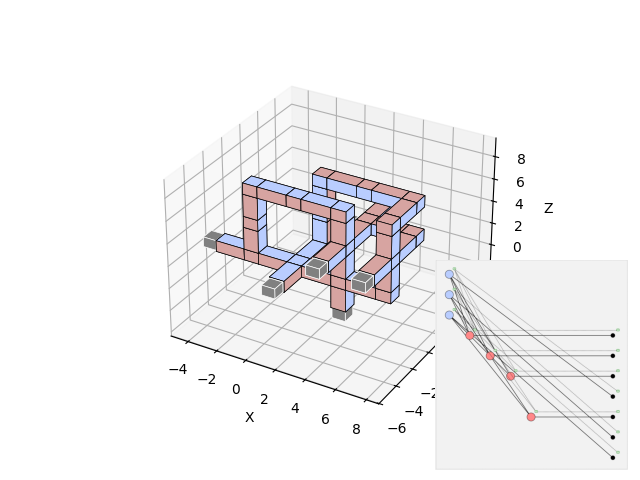

In [9]:
# Parameters & hyper-parameters
circuit_name = f"steane_from_{base_platform}"
visualisation = "final"  # Calls 3D visualisation at the end. `None` to deactivate.
animation = None  # Change to "GIF" or "MP4" for a summary animation (significant runtime costs).

VALUE_FUNCTION_HYPERPARAMS = (
    -1,  # Weight for length of path
    -1,  # Weight for number of "beams" broken by path
)

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": 9,
}

# Run topologiq
simple_graph_after_use, edge_pths, lattice_nodes, lattice_edges = runner(
    simple_graph,  # The PyZX input graph, simplified
    circuit_name,  # The name of the circuit
    visualise=(visualisation, animation),
    fig_data=fig_data,
    **kwargs
)

And we can print topologiq's outputs to inspect them, in particular, `lattice_nodes` and `lattice_edges`, which will become a TQEC `block_graph`.

In [10]:
if lattice_nodes and lattice_edges:
    print("\nCubes in final output:")
    for k, v in lattice_nodes.items():
        print(f"{k}:{v}")

    print("\nPipes in final output:")
    for k, v in lattice_edges.items():
        print(f"{k}:{v}")

else:
    print("WARNING! Some key objects needed to create the block_graph do not exist. Please check that topologiq ran and succeeded.")


Cubes in final output:
30:((0, 0, 0), 'xxz')
11:((3, 0, 0), 'zxz')
15:((-3, 0, 0), 'zxz')
25:((0, 3, 0), 'xzz')
49:((0, -3, 0), 'ooo')
10:((3, 0, 3), 'zxx')
56:((6, 0, 0), 'zxz')
20:((6, 0, 3), 'zxx')
43:((3, 0, -3), 'ooo')
45:((-6, 0, 0), 'ooo')
47:((0, 6, 0), 'ooo')
13:((3, 3, 3), 'zzx')
46:((3, -3, 3), 'ooo')
48:((6, -3, 3), 'ooo')
44:((3, 6, 3), 'ooo')
66:((3, 0, 6), 'zxz')
68:((0, 0, 6), 'xxz')
70:((-3, 0, 6), 'zxz')
72:((-3, 0, 3), 'zxx')
75:((6, 3, 3), 'zzx')
78:((6, 0, 6), 'zxx')
80:((6, 3, 6), 'zzx')
82:((3, 3, 6), 'zzx')
84:((0, 3, 6), 'xzx')
86:((0, 3, 3), 'xzz')

Pipes in final output:
(30, 11):['oxz', (30, 11)]
(30, 15):['oxz', (30, 15)]
(30, 25):['xoz', (30, 25)]
(30, 49):['xoz', (30, 49)]
(11, 10):['zxo', (11, 10)]
(11, 56):['oxz', (11, 20)]
(56, 20):['zxo', (11, 20)]
(11, 43):['zxo', (11, 43)]
(15, 45):['oxz', (15, 45)]
(25, 47):['xoz', (25, 47)]
(10, 13):['zox', (10, 13)]
(10, 46):['zox', (10, 46)]
(20, 48):['zox', (20, 48)]
(13, 44):['zox', (13, 44)]
(10, 66):['zxo',

## Importing to TQEC

The structure of `lattice_nodes` and `lattice_edges` is essentially the same as TQEC's `block_graph`, with one caveat.

There is a need to perform some re-scaling and re-indexing of edges. In TQEC's `block_graph`, pipes occupy no space, which leads to adjacent cubes being closer to one another than in a space-time diagram where pipes do occupy space for the purposes of visualising things clearly.

Fortunately, TQEC already has a way to import 3D objects like `lattice_nodes` and `lattice_edges`. TQEC can import 3D models encoded in COLLADA format (.dae), which use the same kind of coordinates and artifacts as `lattice_nodes` and `lattice_edges`. Accordingly, the following block of code relies on TQEC's COLLADA interoperability to realise similar transformations for `lattice_nodes` and `lattice_edges`, leading into a `block_graph`.

In [11]:
from tqec.interop.collada.read_write import read_from_lattice_dicts

if lattice_nodes and lattice_edges:

    # Import using standardised method for importing lattice surgeries / space-time diagram into TQEC
    lattice_edges_min = dict([(k,v[0]) for k,v in lattice_edges.items()])
    block_graph = read_from_lattice_dicts(lattice_nodes, lattice_edges_min, graph_name=circuit_name)
    
    # Visualise using TQEC methods
    html = block_graph.view_as_html()
    display(html)

    # Release visualisation resources by clearing IPython output
    clear_output()

You may have noticed the imported blockgraph lacks the boundary nodes / port cubes, the ones seen in gray in topologiq's 3D visualisation. 

This is normal. The TQEC import adds transparent placeholder objects at those coordinates.

To enable computation, these need to be "filled", which is done as follows.

In [12]:
if block_graph:
    
    # Fill ports using function that yields minimal set of block_graphs needed for simulation
    filled_block_graphs = block_graph.fill_ports_for_minimal_simulation()
    
    # Show all block_graphs in minimal set
    for i, block_graph in enumerate(filled_block_graphs):

        for j, correlation_surface in enumerate(block_graph.observables):
            block_graph.graph.view_as_html(
                pop_faces_at_directions=("-Y", "+X"),
                show_correlation_surface=block_graph.observables[j],
            )

            html = block_graph.graph.view_as_html(
                pop_faces_at_directions=("-Y", "+X"),
                show_correlation_surface=block_graph.observables[j],
            )

            display(html)

    # Release visualisation resources by clearing IPython output
    clear_output()

And we can now use the blockgraph to perform TQEC operations. 

Let's start by getting the Stim circuit for different bases. 

In [13]:
import sinter
from tqec.computation.block_graph import BlockGraph
from tqec import compile_block_graph, NoiseModel
from tqec.utils.enums import Basis
from tqec.simulation.plotting.inset import plot_observable_as_inset
from tqec.simulation.simulation import start_simulation_using_sinter

# Function to get the correct filled_graphs for each basis
def graphs_for_given_basis(pre_filled_block_graphs, observable_basis: Basis) -> BlockGraph | None:
    
    filled_graphs = pre_filled_block_graphs
    assert len(filled_graphs) == 2
    if observable_basis == Basis.X:
        return filled_graphs[0].graph
    elif observable_basis == Basis.Z:
        return filled_graphs[1].graph

# Function to get Stim circuit for given basis
def get_stim_circuit(pre_filled_block_graphs):

    block_graph_for_computation = graphs_for_given_basis(pre_filled_block_graphs, Basis.X)
    if block_graph_for_computation:
        compiled_graph = compile_block_graph(block_graph_for_computation)
        stim_circuit = compiled_graph.generate_stim_circuit(
            k=1, noise_model=NoiseModel.uniform_depolarizing(p=0.001)
        )
        print("\nFirst 10 lines of Stim circuit (Basis X):\n")
        print(stim_circuit[:10])
    
    block_graph_for_computation = graphs_for_given_basis(pre_filled_block_graphs, Basis.Z)
    if block_graph_for_computation:
        compiled_graph = compile_block_graph(block_graph_for_computation)
        stim_circuit = compiled_graph.generate_stim_circuit(
            k=1, noise_model=NoiseModel.uniform_depolarizing(p=0.001)
        )
        print("\nFirst 10 lines of Stim circuit (Basis Z):\n")
        print(stim_circuit[:10])

# Call Stim circuit generation for all relevant bases
if filled_block_graphs:
    get_stim_circuit(filled_block_graphs)


First 10 lines of Stim circuit (Basis X):

QUBIT_COORDS(-16, 0) 0
QUBIT_COORDS(-16, 2) 1
QUBIT_COORDS(-16, 4) 2
QUBIT_COORDS(-16, 6) 3
QUBIT_COORDS(-15, 1) 4
QUBIT_COORDS(-15, 3) 5
QUBIT_COORDS(-14, 0) 6
QUBIT_COORDS(-14, 2) 7
QUBIT_COORDS(-14, 4) 8
QUBIT_COORDS(-14, 6) 9

First 10 lines of Stim circuit (Basis Z):

QUBIT_COORDS(-16, 0) 0
QUBIT_COORDS(-16, 2) 1
QUBIT_COORDS(-16, 4) 2
QUBIT_COORDS(-16, 6) 3
QUBIT_COORDS(-15, 1) 4
QUBIT_COORDS(-15, 3) 5
QUBIT_COORDS(-15, 5) 6
QUBIT_COORDS(-14, 0) 7
QUBIT_COORDS(-14, 2) 8
QUBIT_COORDS(-14, 4) 9


And let's now run a simulation. 

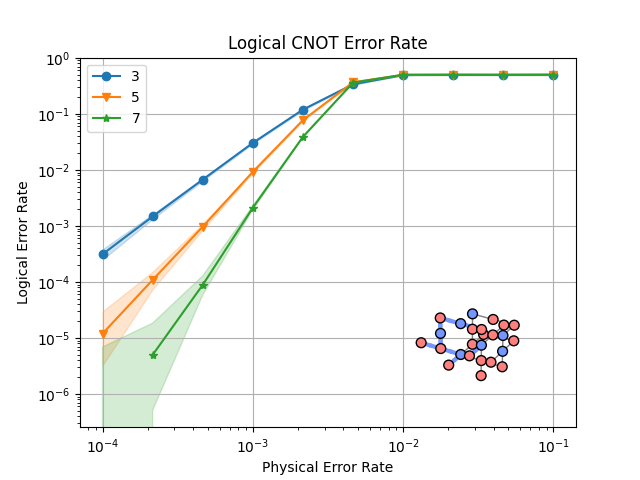

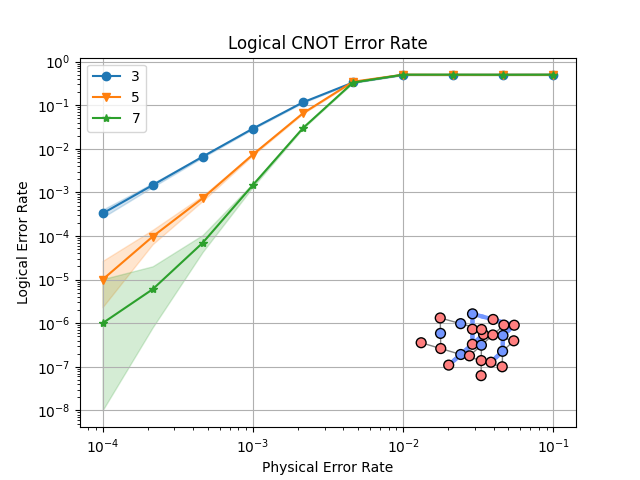

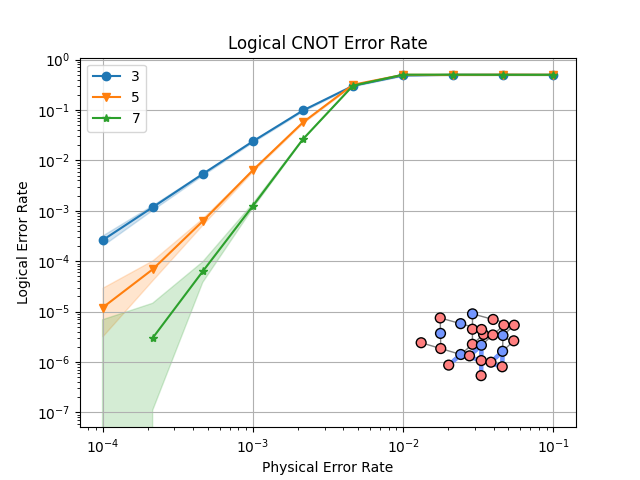

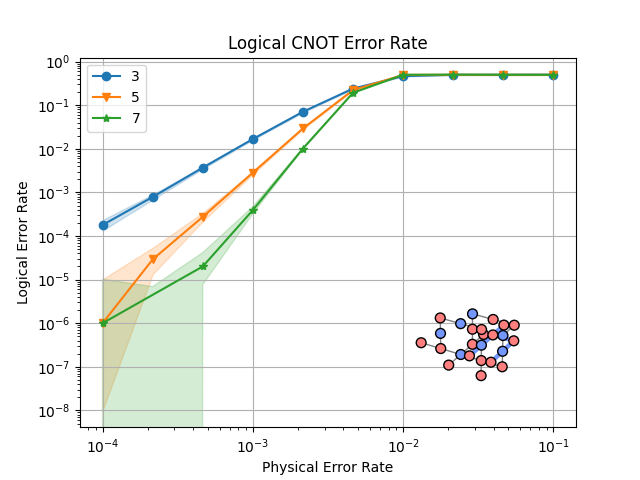

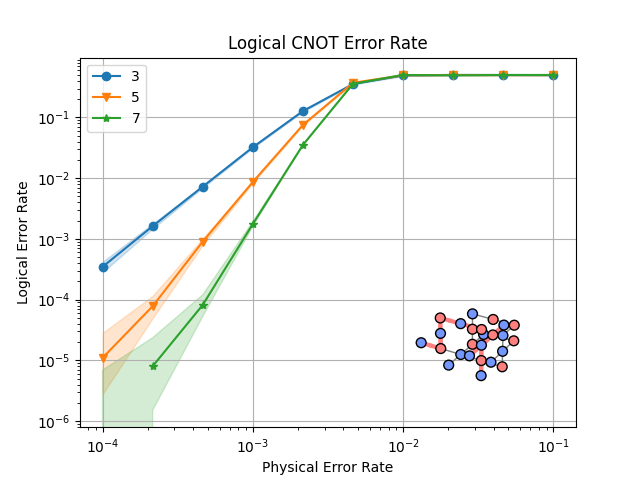

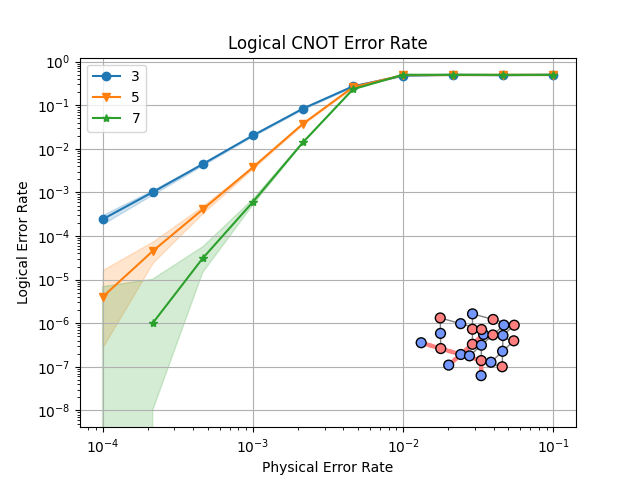

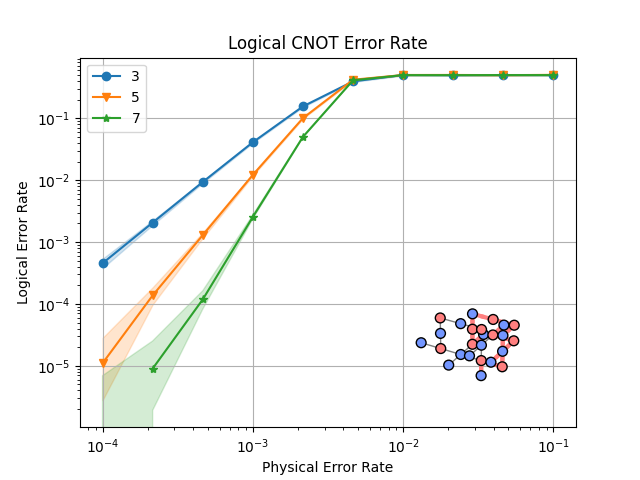

In [14]:
# Function to generate simulation graphs
def generate_graphs(pre_filled_block_graphs, support_observable_basis: Basis, SAVE_DIR) -> None:

    # Get block_graph from set of pre_filled block_graphs
    block_graph_for_simulation = graphs_for_given_basis(pre_filled_block_graphs, support_observable_basis)
    
    # Start sinter
    if block_graph_for_simulation:

        # ZX-graph to overlay over output
        zx_graph_for_simulation = block_graph_for_simulation.to_zx_graph()

        # Correlation surfaces for simulation
        correlation_surfaces_for_simulation = block_graph_for_simulation.find_correlation_surfaces()
        
        # Call Sinter
        stats = start_simulation_using_sinter(
            block_graph_for_simulation,
            range(1, 4),
            list(np.logspace(-4, -1, 10)),
            NoiseModel.uniform_depolarizing,
            manhattan_radius=2,
            observables=correlation_surfaces_for_simulation,
            max_shots=1_000_000,
            max_errors=5_000,
            decoders=["pymatching"],
            print_progress=False,
            save_resume_filepath=Path(
                f"../_examples_database/steane_stats_{support_observable_basis.value}.csv"
            ),
            database_path=Path("../_examples_database/database.pkl"),
        )

        # Visualise output
        for i, stat in enumerate(stats):
            fig, ax = plt.subplots()
            sinter.plot_error_rate(
                ax=ax,
                stats=stat,
                x_func=lambda stat: stat.json_metadata["p"],
                group_func=lambda stat: stat.json_metadata["d"],
            )
            plot_observable_as_inset(ax, zx_graph_for_simulation, correlation_surfaces_for_simulation[i])
            ax.grid(axis="both")
            ax.legend()
            ax.loglog()
            ax.set_title("Logical CNOT Error Rate")
            ax.set_xlabel("Physical Error Rate")
            ax.set_ylabel("Logical Error Rate")
            fig.savefig(
                SAVE_DIR
                / f"logical_cnot_result_{support_observable_basis}_observable_{i}.png"
            )

# Function to cal simulation cycle for all relevant bases
def run_simulation(pre_filled_block_graphs, SAVE_DIR):
    SAVE_DIR.mkdir(exist_ok=True)
    generate_graphs(pre_filled_block_graphs, Basis.Z, SAVE_DIR)
    generate_graphs(pre_filled_block_graphs, Basis.X, SAVE_DIR)

# Call simulation cycle
if filled_block_graphs:
    SAVE_DIR = Path("results")
    run_simulation(filled_block_graphs, SAVE_DIR)